# Imports

In [1]:
# imports
from typing import Tuple, List
from collections import deque

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Optimizer

import numpy as np
from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss

torch.manual_seed(20190325);

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1305,), (0.3081,))
])

In [4]:
# https://pytorch.org/docs/stable/data.html
train_dataset = MNIST(root='../mnist_data/',
                      train=True, 
                      download=True,
                      transform=img_transforms)

test_dataset = MNIST(root='../mnist_data/',
                     train=False, 
                     download=True,
                     transform=img_transforms)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=60, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=60, 
                                           shuffle=False)

In [6]:
from model import Autoencoder
from train import PyTorchTrainer

# Unsupervised Learning with Autoencoder

## Preprocess data

In [7]:
mnist_train = ((train_dataset.data.type(torch.float32).unsqueeze(3).permute(0, 3, 1, 2) / 255.0) - 0.1305) / 0.3081
mnist_test = ((test_dataset.data.type(torch.float32).unsqueeze(3).permute(0, 3, 1, 2) / 255.0) - 0.1305) / 0.3081

In [8]:
X_train = mnist_train
X_test = mnist_test

In [9]:
X_train_auto = (X_train - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1
X_test_auto = (X_test - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1

In [10]:
model = Autoencoder()

In [11]:
model = Autoencoder(hidden_dim=28)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

trainer = PyTorchTrainer(model, optimizer, criterion)

trainer.fit(X_train_auto, X_train_auto,
            X_test_auto, X_test_auto,
            epochs=1,
            batch_size=60)

The loss after 1 epochs was 0.06897220760583878


In [12]:
reconstructed_images, image_representations = model(X_test_auto)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
def display_image(ax,
    t: Tensor):
    n = t.detach().numpy()
    ax.imshow(n.reshape(28, 28))

In [15]:
np.random.seed(20190504)
a = np.random.randint(0, 10000)

In [16]:
X_test[a].shape

torch.Size([1, 28, 28])

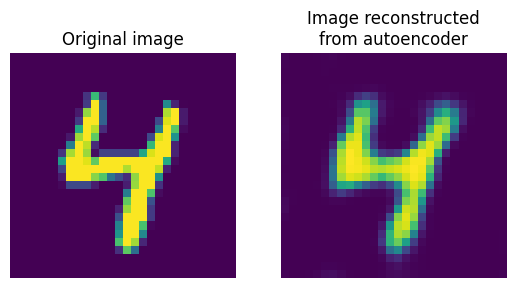

In [17]:
f, axarr = plt.subplots(1,2)
display_image(axarr[0], X_test[a])
display_image(axarr[1], reconstructed_images[a])

axarr[0].set_title("Original image")
axarr[1].set_title("Image reconstructed\nfrom autoencoder")

axarr[0].axis('off')
axarr[1].axis('off');

# f.savefig("../../01_deep-learning-from-scratch/images/07_pytorch/03_autoencoder_example_image.png")

# $t$-SNE on the results

In [18]:
from sklearn.manifold import TSNE
tsne_result = TSNE(n_components=2, random_state=20190405).fit_transform(image_representations.detach().numpy())

## $t$-SNE viz

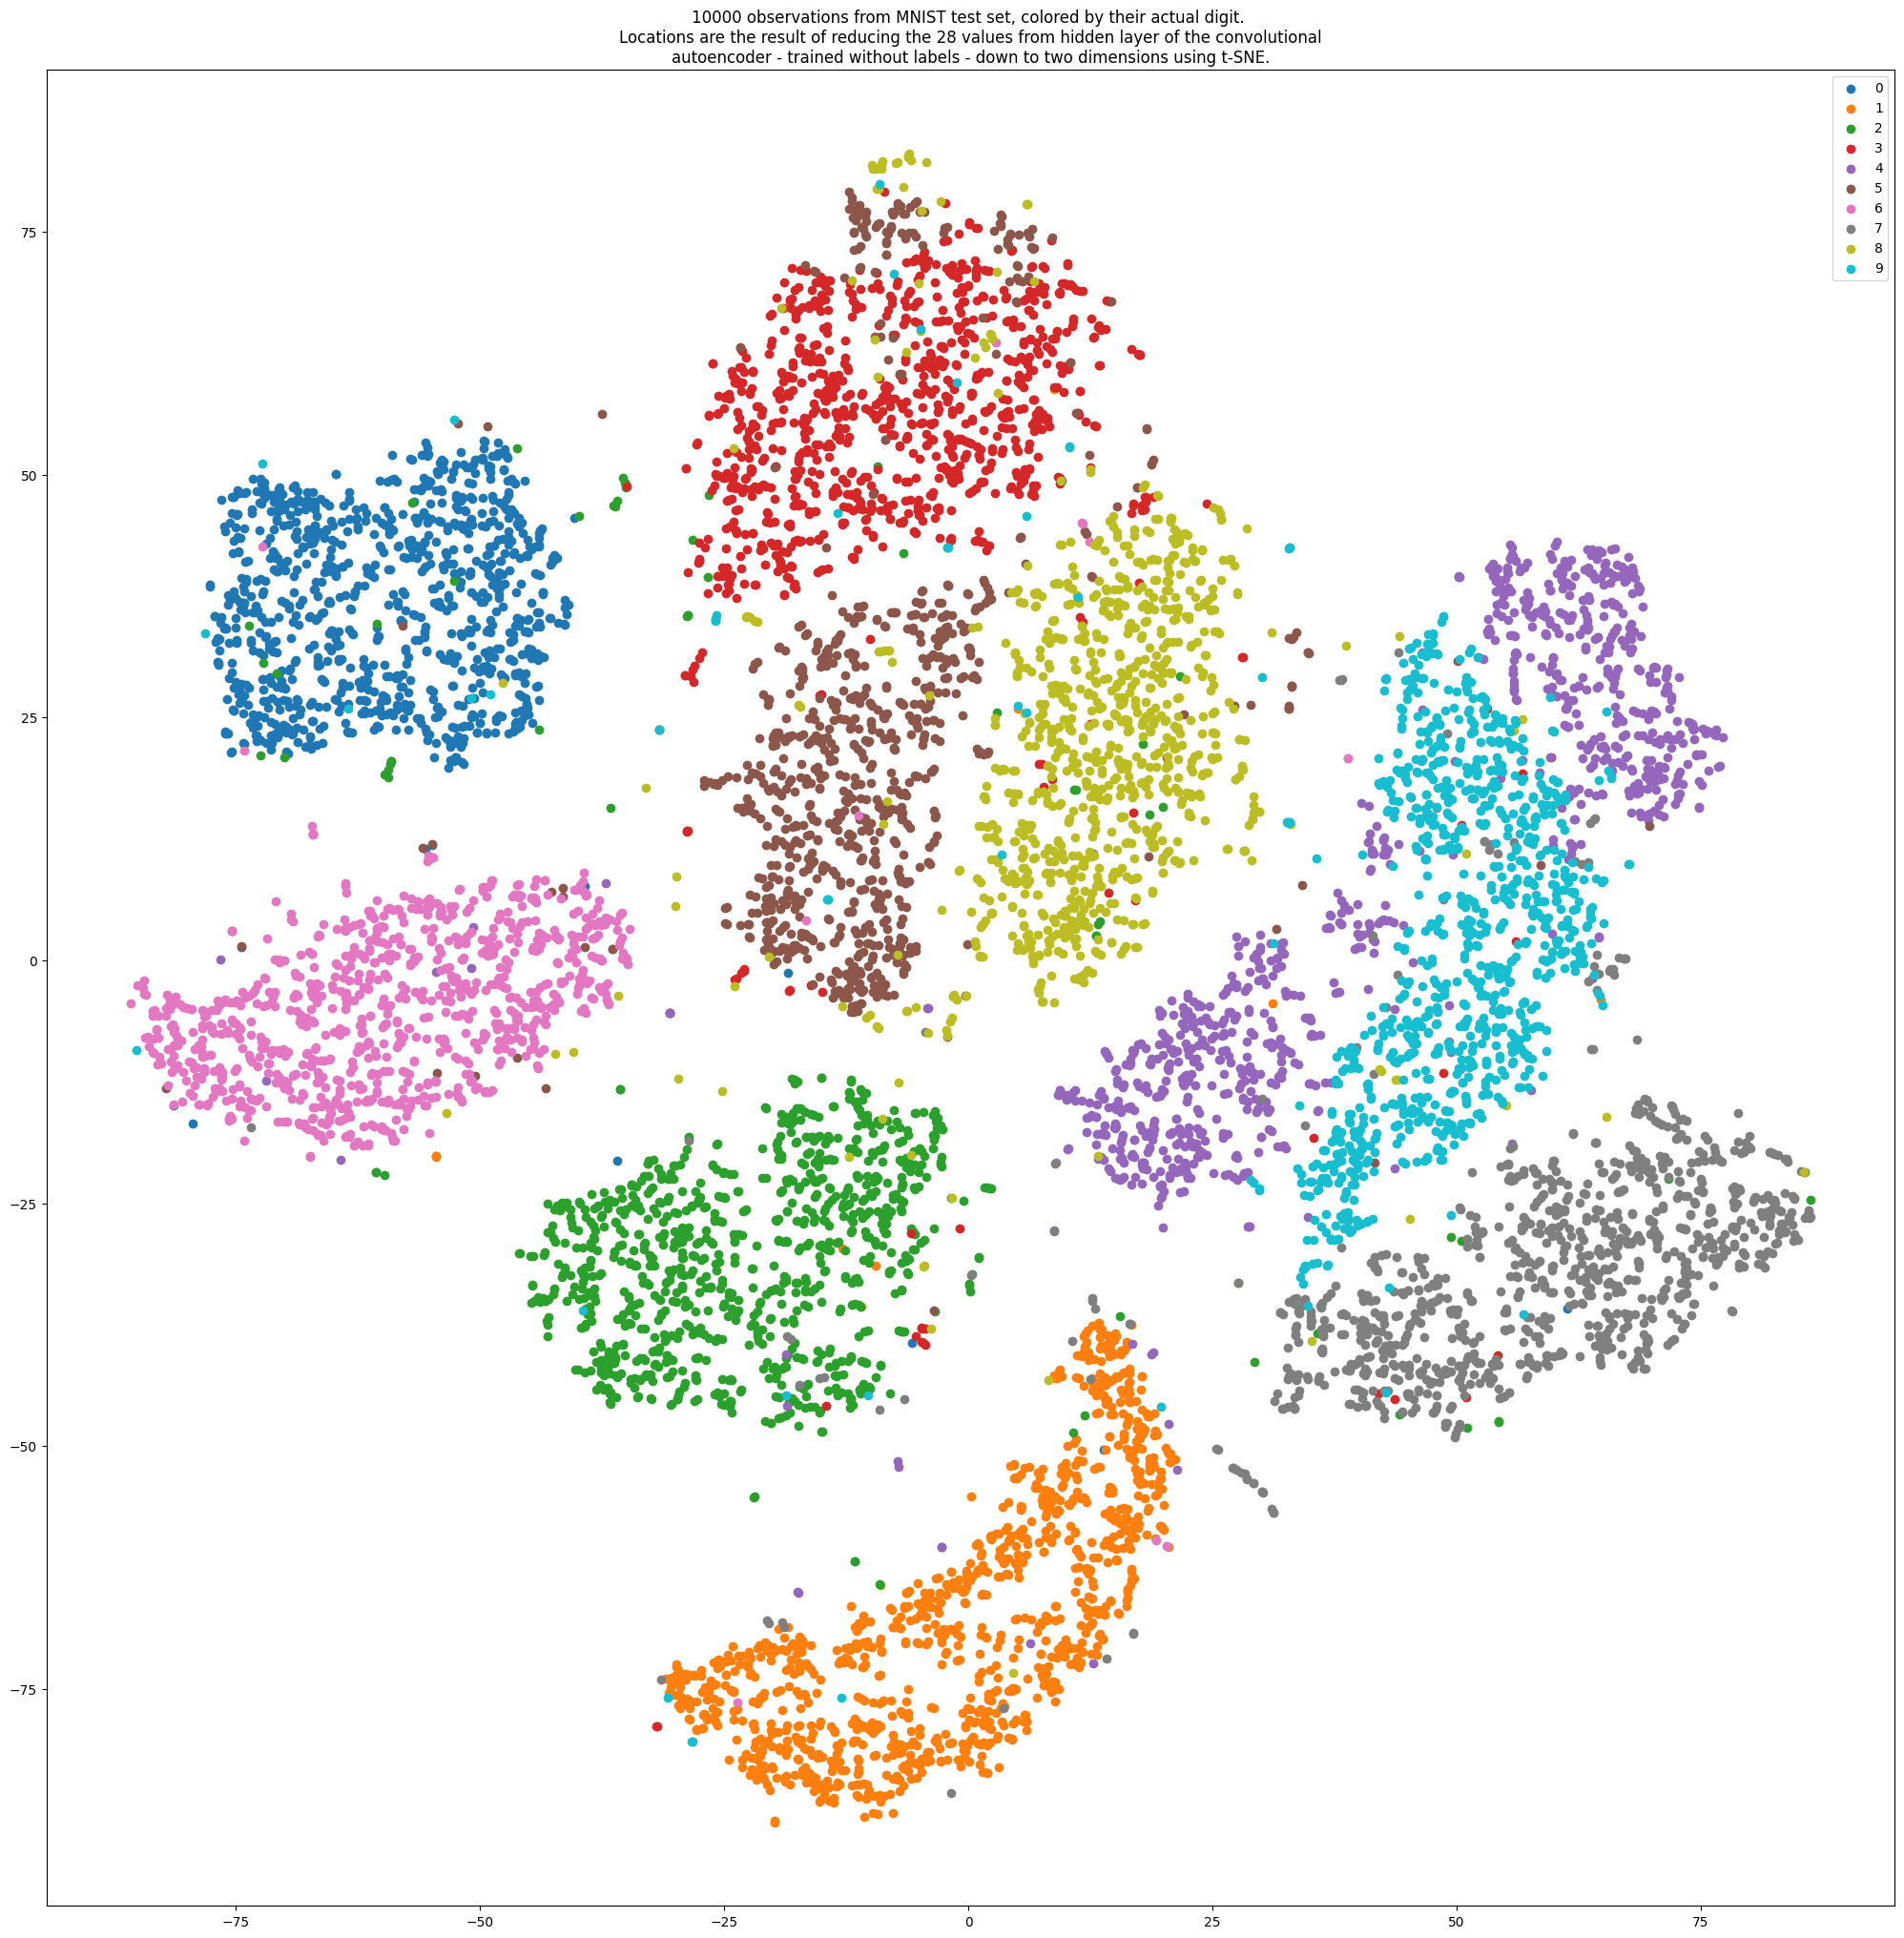

In [19]:
import pandas as pd
tsne_df = pd.DataFrame({'tsne_dim_1': tsne_result[:,0],
              'tsne_dim_2': tsne_result[:,1],
              'category': test_dataset.targets})
groups = tsne_df.groupby('category')

# Plot
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title('''10000 observations from MNIST test set, colored by their actual digit. 
Locations are the result of reducing the 28 values from hidden layer of the convolutional
autoencoder - trained without labels - down to two dimensions using t-SNE.''')
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.scatter(group['tsne_dim_1'], group['tsne_dim_2'], marker='o', label=name)
ax.legend();

In [20]:
fig.savefig("tsne.png")